In [7]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
import itertools

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"

seed_value = 1
np.random.seed(seed_value) # cpu vars
torch.manual_seed(seed_value) # cpu  vars
random.seed(seed_value) # Python
    
    #if use_cuda: 
torch.cuda.manual_seed_all(seed_value) # gpu vars
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

#random_seed(1234, True)

# random_seed(1234, False)
#torch.manual_seed(0)

%matplotlib inline

In [8]:
# To-Do:  add prof. dataset .npy

class MyDataset(Dataset):
    def __init__(self, file_path):
        self.files = file_path
        self.data = np.load(self.files)
        
    def __getitem__(self, index):
        x = torch.from_numpy(self.data).float()
        return x[index]
        
    def __len__(self):
        return len(self.data)


class CustomView:
    def __init__(self,new_size):
        self.new_size = new_size
    def __call__(self, img):
        return torch.reshape(img, self.new_size)

In [21]:
batch_size = 100
transform = [torchvision.transforms.ToTensor(), CustomView((-1,))]
mnist_trainset = MyDataset('mnist_train_images.npy')
train_loader= torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

test_batch_size = 16
test_loader = torch.utils.data.DataLoader(mnist_trainset,batch_size=test_batch_size, shuffle=False)

In [23]:
print(next(iter(test_loader)).size())

'''
batches, channels, dim_x, dim_y
batches=image.shape[0], (flatten(dim_x, dim_y))
'''

torch.Size([16, 784])


'\nbatches, channels, dim_x, dim_y\nbatches=image.shape[0], (flatten(dim_x, dim_y))\n'

In [11]:
class VAE(nn.Module):
    def __init__(self,num_inputs, num_hidden, code_size, drop_prob):
        super(VAE, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.code_size = code_size
        self.drop_prob = drop_prob

        self.Q = nn.Linear(self.num_inputs, self.num_hidden)

        self.mu = nn.Linear(self.num_hidden, self.code_size)
        self.var = nn.Linear(self.num_hidden, self.code_size)
          
        self.P = nn.Linear(self.code_size, self.num_hidden)
        self.output = nn.Linear(self.num_hidden, self.num_inputs)
        
        
        self.dropout = nn.Dropout(self.drop_prob)
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self, x):
        x = self.dropout(torch.tanh(self.Q(x)))
        mu = self.dropout(torch.tanh(self.mu(x)))
        sigma = self.dropout(torch.tanh(self.var(x))) # should we multiple for 0.5 or hjust exp
        return mu, sigma
    
    def decoder(self, z):
        p = torch.tanh(self.P(z))
        out = self.sigmoid(self.output(p))
        return out
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        mu, sigma = self.encoder(x)
        z = torch.empty(self.code_size).normal_(mean=0,std=1).to(device) * torch.exp(sigma) + mu #[batch, L=monte carlo steps, z_dim]
        out = self.decoder(z)
        return out, mu, sigma

In [12]:
def criterion(output, ground_truth, mu, var, L):
    # what is the shape of my output??
#     log_like = torch.log() # get the log loss between each vector between the output and the ground_truth
    
    # todo change this *****************
    BCE = F.binary_cross_entropy(output, ground_truth.view(-1, 784), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + torch.log(var**2) - mu**2 - var**2)
    KLD = -0.5 * torch.sum(1 + var - mu**2 - torch.exp(var))
    
#     todo change this *****************

    return (L*BCE) + KLD

In [13]:
def epoch_time(init_time, end_time):
    elapsed_time = end_time - init_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
def training(loader, model, optimizer, L):
    train_loss = 0
    train_losses = []
        
    model.train()
    for i, images in enumerate(loader, start=1):
        model.zero_grad()
        images = images.to(device)
            
        outputs, mu, var = model(images)
        loss = criterion(outputs, images, mu, var, L).to(device)
            
        loss.backward()
        optimizer.step()
            
        train_loss += loss.detach().item()
        
    train_loss = train_loss/i
    train_losses.append(train_loss)
    
    return train_loss, train_losses    
    

Drop_ prob [0.05], Learning Rate[0.001], Epochs[1]
Epoch: 00 | Epoch Time: 0m 3s
	 Train Loss:2696.8653
		 Better accuracy: 2696.8653058416194
Drop_ prob [0.05], Learning Rate[0.001], Epochs[1]


/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 00 | Epoch Time: 0m 2s
	 Train Loss:7106.0970
Drop_ prob [0.05], Learning Rate[0.001], Epochs[1]
Epoch: 00 | Epoch Time: 0m 2s
	 Train Loss:11274.2256
Drop_ prob [0.05], Learning Rate[0.001], Epochs[1]
Epoch: 00 | Epoch Time: 0m 2s
	 Train Loss:15547.3677
Drop_ prob [0.05], Learning Rate[0.001], Epochs[1]
Epoch: 00 | Epoch Time: 0m 2s
	 Train Loss:21699.9740
torch.Size([1, 784])


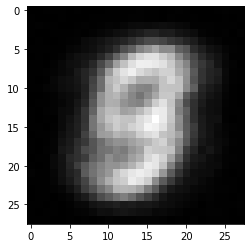

In [16]:
def main():
    num_inputs=784 
    num_hidden=200 
    code_size=32 
    
    drop_probs = [0.05]
    learning_rates = [1e-3]
    epochs = [1]
    L = [0.1, 0.3, 0.5, 0.7, 1]
        
    hyperparams = list(itertools.product(drop_probs, learning_rates,epochs, L))     
    best_train_loss = float('inf')
    
    for drop_prob, lr, epochs, l in hyperparams:
        
        model = VAE(num_inputs=num_inputs, num_hidden=num_hidden, code_size=code_size, drop_prob=drop_prob).to(device)    
        optimizer = optim.Adam(model.parameters(), lr=lr)    
        
        print('Drop_ prob [{}], Learning Rate[{}], Epochs[{}]'.format(drop_prob, lr, epochs)) 
        
        for epoch in range(epochs):
            init_timer=time.time()

            train_loss, train_losses = training(train_loader, model, optimizer, l)

            end_timer = time.time()
            epoch_mins, epoch_secs = epoch_time(init_timer, end_timer)

            print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print('\t Train Loss:%.4f'%(train_loss))
            
            checkpoint = {'model':model,'state_dict':model.state_dict(), 'optimizer':optimizer.state_dict()}
            torch.save(checkpoint, f'checkpoint_{epoch}_{lr}_{drop_probs}_{l}.pth')
            
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                print(f"\t\t Better accuracy: {best_train_loss}")
                checkpoint = {'model':model,
                              'train_loss':best_train_loss,
                              'hyperparams': [drop_prob, lr, epochs],
                              'state_dict':model.state_dict(),
                              'optimizer':optimizer.state_dict()}

                torch.save(checkpoint, 'last_checkpoint.pth')
        
    example = torch.rand(1,32).to(device)
    example = model.decoder(example)
    print(example.size())
    example = example.cpu().detach().numpy().reshape(28,28)
    plt.imshow(example, cmap='gray', interpolation='none')
    plt.show()

        
if __name__ == '__main__':
    main()

In [17]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    print(checkpoint['train_loss'])
    drop_prob, lr, epochs = checkpoint['hyperparams']
    print('Drop_ prob [{}], Learning Rate[{}], Epochs[{}]'.format(drop_prob, lr, epochs)) 
    return model

In [18]:
model = load_checkpoint('last_checkpoint.pth')

def generator(model):
    z=torch.randn(1,32).to(device) 
    rand_sample = model.decoder(z)
    return rand_sample.cpu().detach().numpy().reshape(28,28)

# best hyperparameters so far
# 1747.598043359375
# Drop_ prob [0.01], Learning Rate[0.001], Epochs[100]


2696.8653058416194
Drop_ prob [0.05], Learning Rate[0.001], Epochs[1]


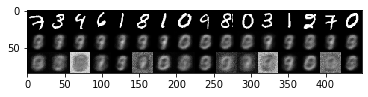

In [24]:
image = np.zeros((28,1))
images_2 = np.zeros((28,1))
generated_images = np.zeros((28,1))

for img in next(iter(test_loader)):
    a = img.numpy().reshape(28,28)
    image = np.concatenate((image,a), axis=1)
    # recreate the images
    outputs, mu, var  = model(img.to(device))
    images_2 = np.concatenate((images_2, outputs.cpu().detach().numpy().reshape(28,28)),axis=1)
    # generate images
    generated_images = np.concatenate((generated_images, generator(model)),axis=1)

a = np.vstack((image,images_2))
a = np.vstack((a,generated_images))
    
plt.imshow(a, cmap='gray', interpolation='none')
plt.show()


In [290]:
# generator must have the mu and std values saved to later use on the decoder()?
# L=monte carlos step can be assumed ad 1 based on paper, should we still code the L implementation or assumed is one?
# can we load the mnist dataset using pytorch loader, in  order to used our custom Dataset to maker easier minibatches?

#how was your lowest loss?
#which hyperparamter are free to change?
# - what was your dropout prob